In [1]:
%run "13 - Full CGE with Trade.ipynb"

Found 18 variables; unrolled count 75
Found 18 parameters; unrolled count 93
Found 14 equations; unrolled count 66
Output shapes: [(3,), (3, 3), (3, 3), (3, 3), (3, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,)]
Found 14 variables; unrolled count 207
Found 17 parameters; unrolled count 270
Found 14 equations; unrolled count 198
Output shapes: [(9,), (3, 9), (3, 9), (3, 9), (3, 9), (9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,)]
Found 5 variables; unrolled count 46
Found 8 parameters; unrolled count 65
Found 5 equations; unrolled count 37
Output shapes: [(9,), (9,), (9,), (), (9,)]
Found 14 variables; unrolled count 23
Found 21 parameters; unrolled count 39
Found 14 equations; unrolled count 22
Output shapes: [(3,), (3,), (3,), (), (3,), (), (), (), (), (), (), (), (), ()]
Found 7 variables; unrolled count 49
Found 12 parameters; unrolled count 74
Found 8 equations; unrolled count 48
Output shapes: [(3,), (3,), (3,), (9,), (9,), (9,), (3,), (9,)]
Found 4 variables; unro

# Calibration

In [2]:
mod = CGEModel(
    variables=all_variables,
    parameters=all_parameters,
    equations=all_equations,
    coords=coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
    compile=True,
)

Beginning compilation in JAX mode
Compiling CGE equations into JAX function
Compiling Jacobian equations into JAX function
Computing sum of squared errors
Computing SSE gradient
Computing SSE Jacobian
Compiling SSE functions (sse, gradient, jacobian) into JAX function


In [3]:
df_jittered = df + 1e-6

In [4]:
initial_data = {
    "income_tax_revenue": df_jittered.loc[("Tax", "Income"), "Factors"],
    "production_tax_revenue": df_jittered.loc[("Tax", "Production"), "Activities"].loc[
        sector_codes
    ],
    "factor_tax_revenue": df_jittered.loc["Factor Tax", "Activities"].loc[:, sector_codes],
    "domestic_sales_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Institution"].loc[
        sector_codes
    ],
    "domestic_VAT_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Activities"].loc[
        sector_codes, sector_codes
    ],
    "import_sales_tax_revenue": df_jittered.loc["Import Sales Tax", "Institution"].loc[
        sector_codes
    ],
    "import_VAT_tax_revenue": df_jittered.loc["Import Sales Tax", "Activities"].loc[
        sector_codes, sector_codes
    ],
    "import_duty_revenue": df_jittered.loc[("Tax", "Import Duty"), "Imported Commodities"].loc[
        sector_codes
    ],
    "export_duty_revenue": df_jittered.loc[("Tax", "Export Duty"), "Domestic Commodities"].loc[
        sector_codes
    ],
    "energy_production_tax_revenue": df_jittered.loc[("Tax", "Production"), "Activities"].loc[
        energy_codes
    ],
    "energy_domestic_VAT_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Activities"].loc[
        sector_codes, energy_codes
    ],
    "energy_domestic_sales_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Institution"].loc[
        energy_codes
    ],
    "energy_import_VAT_tax_revenue": df_jittered.loc["Import Sales Tax", "Activities"].loc[
        sector_codes, energy_codes
    ],
    "energy_import_sales_tax_revenue": df_jittered.loc["Import Sales Tax", "Institution"].loc[
        energy_codes
    ],
    "energy_import_duty_revenue": df_jittered.loc[
        ("Tax", "Import Duty"), "Imported Commodities"
    ].loc[energy_codes],
    "energy_export_duty_revenue": df_jittered.loc[
        ("Tax", "Import Duty"), "Domestic Commodities"
    ].loc[energy_codes],
    "energy_factor_tax_revenue": df_jittered.loc["Factor Tax", "Activities"].loc[:, energy_codes],
    "factor_demand": df_jittered.loc["Factors", "Activities"].loc[:, sector_codes],
    "X": df_jittered.loc["Domestic Commodities", "Activities"].loc[sector_codes, sector_codes],
    "X_M": df_jittered.loc["Imported Commodities", "Activities"].loc[sector_codes, sector_codes],
    "Y": df_jittered["Activities"].loc[:, sector_codes].sum(axis=0),
    "M": df_jittered.loc[:, "Imported Commodities"].loc[:, sector_codes].sum(axis=0),
    "energy_factor_demand": df_jittered.loc["Factors", "Activities"].loc[:, energy_codes],
    "X_E": df_jittered.loc["Domestic Commodities", "Activities"].loc[sector_codes, energy_codes],
    "X_E_M": df_jittered.loc["Imported Commodities", "Activities"].loc[sector_codes, energy_codes],
    "Y_E": df_jittered["Activities"].loc[:, energy_codes].sum(axis=0),
    "M_E": df_jittered.loc[:, "Imported Commodities"].loc[:, energy_codes].sum(axis=0),
    "Ex": df_jittered.loc["Domestic Commodities", ("Trade", "Rest of World")].loc[sector_codes],
    "Ex_E": df_jittered.loc["Domestic Commodities", ("Trade", "Rest of World")].loc[energy_codes],
    "household_electricity_demand": df_jittered.loc[
        ("Factors", "Electricity"), ("Institution", "Household")
    ],
    "household_electricity_tax_revenue": df_jittered.loc[
        ("Factor Tax", "Electricity"), ("Institution", "Household")
    ],
    "domestic_institution_demand": df_jittered.loc["Domestic Commodities", "Institution"].loc[
        sector_codes
    ],
    "import_institution_demand": df_jittered.loc["Imported Commodities", "Institution"].loc[
        sector_codes
    ],
    "energy_domestic_institution_demand": df_jittered.loc[
        "Domestic Commodities", "Institution"
    ].loc[energy_codes],
    "energy_import_institution_demand": df_jittered.loc["Imported Commodities", "Institution"].loc[
        energy_codes
    ],
    "supply_of_savings": df_jittered.loc[("Institution", "Investment")],
    "T": df_jittered.loc[("Factors", "Labor"), ("Activities")].sum() / 0.6,
}


def initialize_parameter(name, mod, value=5.0):
    dims = mod.get(name).dims
    size = [len(mod.coords[dim]) for dim in dims]
    return np.full(size, value)


econometric_estimates = {
    "Theta": 1.0,
    "sigma_C": 1.5,
}
for name in [
    "epsilon_VA",
    "epsilon_KE",
    "epsilon_KE_E",
    "epsilon_VA_E",
    "epsilon_G",
    "epsilon_C",
    "epsilon_CE",
    "epsilon_C_G",
    "epsilon_C_M",
    "epsilon_GM",
    "epsilon_I_E_M",
    "epsilon_I_M",
    "epsilon_X",
    "epsilon_X_E",
]:
    econometric_estimates[name] = initialize_parameter(name, mod, value=0.5)

In [5]:
def calibrate_DX(output, inputs, inputs_price, epsilon):
    rho = (epsilon - 1) / epsilon
    input_purchase_value = inputs_price * inputs ** (1 / epsilon)
    alpha = input_purchase_value / input_purchase_value.sum()
    A = output / (alpha * inputs**rho).sum() ** (1 / rho)

    return A, alpha

## Calibration Function

In [6]:
def calibrate_model(
    *,
    income_tax_revenue,
    production_tax_revenue,
    factor_tax_revenue,
    domestic_sales_tax_revenue,
    domestic_VAT_tax_revenue,
    import_sales_tax_revenue,
    import_VAT_tax_revenue,
    import_duty_revenue,
    export_duty_revenue,
    energy_production_tax_revenue,
    energy_domestic_VAT_tax_revenue,
    energy_domestic_sales_tax_revenue,
    energy_import_VAT_tax_revenue,
    energy_import_sales_tax_revenue,
    energy_factor_tax_revenue,
    energy_import_duty_revenue,
    energy_export_duty_revenue,
    factor_demand,
    X,
    X_M,
    Y,
    M,
    domestic_institution_demand,
    import_institution_demand,
    energy_factor_demand,
    X_E,
    X_E_M,
    Y_E,
    M_E,
    Ex,
    Ex_E,
    energy_domestic_institution_demand,
    energy_import_institution_demand,
    household_electricity_demand,
    household_electricity_tax_revenue,
    supply_of_savings,
    T,
    epsilon_VA,
    epsilon_KE,
    epsilon_KE_E,
    epsilon_VA_E,
    epsilon_G,
    epsilon_C,
    epsilon_CE,
    epsilon_C_G,
    epsilon_C_M,
    epsilon_GM,
    epsilon_I_E_M,
    epsilon_I_M,
    epsilon_X,
    epsilon_X_E,
    Theta,
    sigma_C,
    mod,
):
    Y = Y.values
    Y_E = Y_E.values

    C = domestic_institution_demand["Household"]
    C_G = domestic_institution_demand["Government"]
    I_d = domestic_institution_demand["Investment"]

    C_M = import_institution_demand["Household"]
    C_G_M = import_institution_demand["Government"]
    I_d_M = import_institution_demand["Investment"]

    C = np.stack([C, C_M])
    C_G = np.stack([C_G, C_G_M])
    I_d = np.stack([I_d, I_d_M])
    X = np.stack([X, X_M])
    X_E = np.stack([X_E, X_E_M])

    I_E_d = energy_domestic_institution_demand["Investment"]
    I_E_M_d = energy_import_institution_demand["Investment"]
    Y_E_d = energy_domestic_institution_demand["Grid"]
    Y_E_M_d = energy_import_institution_demand["Grid"]

    I_E_d = np.stack([I_E_d, I_E_M_d])
    Y_E_d = np.stack([Y_E_d, Y_E_M_d])

    S = supply_of_savings[("Institution", "Household")]
    S_G = supply_of_savings[("Institution", "Government")]
    S_M = supply_of_savings[("Trade", "Rest of World")]

    L_d = factor_demand.loc["Labor", :]
    K_d = factor_demand.loc["Capital", :]
    L_E_d = energy_factor_demand.loc["Labor", :]
    K_E_d = energy_factor_demand.loc["Capital", :]
    E_d = factor_demand.loc["Electricity", :]
    E_E_d = energy_factor_demand.loc["Electricity", :]
    E_H_d = household_electricity_demand

    # taxes
    tau_C = (domestic_sales_tax_revenue["Household"] / C[0]).fillna(0.0)
    tau_I = (domestic_sales_tax_revenue["Investment"] / I_d[0]).fillna(0.0)
    tau_C_G = (domestic_sales_tax_revenue["Government"] / C_G[0]).fillna(0.0)

    tau_C_M = (import_sales_tax_revenue["Household"] / C[1]).fillna(0.0)
    tau_I_M = (import_sales_tax_revenue["Investment"] / I_d[1]).fillna(0.0)
    tau_C_G_M = (import_sales_tax_revenue["Government"] / C_G[1]).fillna(0.0)

    tau_C = np.stack([tau_C, tau_C_M])
    tau_I = np.stack([tau_I, tau_I_M])
    tau_C_G = np.stack([tau_C_G, tau_C_G_M])

    tau_E = (factor_tax_revenue.loc["Electricity"] / factor_demand.loc["Electricity"]).fillna(0.0)
    tau_E_H = household_electricity_tax_revenue / E_H_d
    tau_E_E = (energy_factor_tax_revenue.loc["Electricity"] / E_E_d).fillna(0.0)

    tau_I_E = (energy_domestic_sales_tax_revenue["Investment"] / I_E_d[0]).fillna(0.0)
    tau_I_E_M = (energy_import_sales_tax_revenue["Investment"] / I_E_d[0]).fillna(0.0)
    tau_I_E = np.stack([tau_I_E, tau_I_E_M])

    tau_X = (domestic_VAT_tax_revenue / X[0]).fillna(0.0)
    tau_X_M = (import_VAT_tax_revenue / X[1]).fillna(0.0)
    tau_X = np.stack([tau_X, tau_X_M])

    tau_Y = (production_tax_revenue / Y).fillna(0.0)

    tau_X_E = (energy_domestic_VAT_tax_revenue / X_E[0]).fillna(0.0)
    tau_X_E_M = (energy_import_VAT_tax_revenue / X_E[1]).fillna(0.0)
    tau_X_E = np.stack([tau_X_E, tau_X_E_M])

    tau_Ex = (export_duty_revenue / Ex).fillna(0.0).values
    tau_Ex_E = (energy_export_duty_revenue / Ex_E).fillna(0.0).values

    tau_M = (import_duty_revenue / M).fillna(0.0)
    tau_M_E = (energy_import_duty_revenue / M_E).fillna(0.0)

    tau_Y_E = (energy_production_tax_revenue / Y_E).fillna(0.0)

    tau_r = (factor_tax_revenue.loc["Capital"] / factor_demand.loc["Capital"]).fillna(0.0)
    tau_r_E = (
        energy_factor_tax_revenue.loc["Capital"] / energy_factor_demand.loc["Capital"]
    ).fillna(0.0)
    tau_w = (factor_tax_revenue.loc["Labor"] / factor_demand.loc["Labor"]).fillna(0.0)
    tau_w_E = (energy_factor_tax_revenue.loc["Labor"] / energy_factor_demand.loc["Labor"]).fillna(
        0.0
    )

    tau_G = (energy_domestic_sales_tax_revenue["Grid"] / Y_E_d[0]).fillna(0.0)
    tau_G_M = (energy_import_sales_tax_revenue["Grid"] / Y_E_d[1]).fillna(0.0)

    tau_G = np.stack([tau_G, tau_G_M])

    # # Normalize prices to 1
    w = 1.0
    r = 1.0

    P_E = initialize_parameter("P_E", mod, 1.0)
    P_KE = initialize_parameter("P_KE", mod, 1.0)
    P_VA = initialize_parameter("P_VA", mod, 1.0)
    P_VC = initialize_parameter("P_VC", mod, 1.0)
    P_Y = initialize_parameter("P_Y", mod, 1.0)
    P_Y_E = initialize_parameter("P_Y_E", mod, 1.0)
    P_KE_E = initialize_parameter("P_KE_E", mod, 1.0)
    P_VA_E = initialize_parameter("P_VA_E", mod, 1.0)
    P_VC_E = initialize_parameter("P_VC_E", mod, 1.0)
    P = initialize_parameter("P", mod, 1.0)
    P_CE = initialize_parameter("P_CE", mod, 1.0)
    P_C_G = initialize_parameter("P_C_G", mod, 1.0)
    P_I = initialize_parameter("P_I", mod, 1.0)
    P_I_E = initialize_parameter("P_I_E", mod, 1.0)
    P_M = initialize_parameter("P_M", mod, 1.0)
    P_M_E = initialize_parameter("P_M_E", mod, 1.0)
    P_X = initialize_parameter("P_X", mod, 1.0)
    P_X_E = initialize_parameter("P_X_E", mod, 1.0)
    P_bundled_C = initialize_parameter("P_bundled_C", mod, 1.0)
    P_bundled_Y_E = initialize_parameter("P_bundled_Y_E", mod, 1.0)

    P_C_bar = initialize_parameter("P_C_bar", mod, 0.0)
    P_E_H_bar = initialize_parameter("P_E_H_bar", mod, 0.0)

    # # Zero the residual
    resid = 0.0

    # # Factor supplies
    L_s = L_d.sum() + L_E_d.sum()
    K_s = K_d.sum() + K_E_d.sum()
    E_s = E_d.sum() + E_E_d.sum() + E_H_d
    F = T - L_s

    # # Numeraire
    P_num = w

    def compute_bundle(x, tax, p1, p2, p_out):
        return (x[0] * (1 + tax[0]) * p1 + x[1] * (1 + tax[1]) * p2) / p_out

    # # Import/Domestic Bundles
    X_bundled = compute_bundle(X, tau_X, P_Y[:, None], P_M[:, None], P_X)
    X_bundled_E = compute_bundle(X_E, tau_X_E, P_Y[:, None], P_M[:, None], P_X_E)

    C_bundled = compute_bundle(C, tau_C, P_Y, P_M, P_bundled_C)
    C_bundled_G = compute_bundle(C_G, tau_C_G, P_Y, P_M, P_C_G)
    I_bundle = compute_bundle(I_d, tau_I, P_Y, P_M, P_I)
    I_bundle_E = compute_bundle(I_E_d, tau_I_E, P_Y_E, P_M_E, P_I_E)
    Y_bundled_E = compute_bundle(Y_E_d, tau_G, P_Y_E, P_M_E, P_bundled_Y_E)

    # # Firm calibration
    KE = (K_d * (1 + tau_r) * r + E_d * (1 + tau_E) * P_E) / P_KE
    KE_E = (K_E_d * (1 + tau_r_E) * r + E_E_d * (1 + tau_E_E) * P_E) / P_KE_E

    VA = (KE * P_KE + (1 + tau_w) * w * L_d) / P_VA
    VA_E = (KE_E * P_KE_E + (1 + tau_w_E) * w * L_E_d) / P_VA_E

    VC = (P_X * X_bundled).sum(axis=0) / P_VC
    VC_E = (P_X_E * X_bundled_E).sum(axis=0) / P_VC_E

    Y = (P_VA * VA + P_VC * VC) / ((1 - tau_Y) * P_Y)
    Y_E = (P_VA_E * VA_E + P_VC_E * VC_E) / ((1 - tau_Y_E) * P_Y_E)

    # # Final good sector Armington bundle
    A_X, alpha_X = calibrate_two_good_CES(
        fac1=X[0],
        fac2=X[1],
        p1=(1 + tau_X[0]) * P_Y[:, None],
        p2=(1 + tau_X[1]) * P_M[:, None],
        output=X_bundled,
        epsilon=epsilon_X,
    )

    # # Final good sector Value Add
    A_VA, alpha_VA = calibrate_two_good_CES(
        fac1=KE, fac2=L_d, p1=P_KE, p2=(1 + tau_w) * w, output=VA, epsilon=epsilon_VA
    )
    A_KE, alpha_KE = calibrate_two_good_CES(
        fac1=K_d, fac2=E_d, p1=(1 + tau_r) * r, p2=(1 + tau_E) * P_E, output=KE, epsilon=epsilon_KE
    )

    # # Final good value chain
    psi_X = X_bundled / VC[None]

    # # Final good production function
    psi_VA = VA / Y
    psi_VC = VC / Y

    # # Energy sector Armington bundle
    A_X_E, alpha_X_E = calibrate_two_good_CES(
        fac1=X_E[0],
        fac2=X_E[1],
        p1=(1 + tau_X_E[0]) * P_Y[:, None],
        p2=(1 + tau_X_E[1]) * P_M[:, None],
        output=X_bundled_E,
        epsilon=epsilon_X_E,
    )

    # # Energy sector value add
    A_KE_E, alpha_KE_E = calibrate_two_good_CES(
        fac1=K_E_d,
        fac2=E_E_d,
        p1=(1 + tau_r_E) * r,
        p2=(1 + tau_E_E) * P_E,
        output=KE_E,
        epsilon=epsilon_KE_E,
    )

    A_VA_E, alpha_VA_E = calibrate_two_good_CES(
        fac1=KE_E, fac2=L_E_d, p1=P_KE_E, p2=(1 + tau_w_E) * w, output=VA_E, epsilon=epsilon_VA_E
    )

    # # Energy sector value chain
    psi_X_E = X_bundled_E / VC_E[None]

    # # Energy sector final output
    psi_VC_E = VC_E / Y_E
    psi_VA_E = VA_E / Y_E

    # # Grid Armington Bundle
    A_GM, alpha_GM = calibrate_two_good_CES(
        fac1=Y_E_d[0],
        fac2=Y_E_d[1],
        p1=(1 + tau_G[0]) * P_Y_E,
        p2=(1 + tau_G[1]) * P_M_E,
        output=Y_bundled_E,
        epsilon=epsilon_GM,
    )

    # # Grid final output
    A_G, alpha_G = calibrate_DX(E_s, Y_bundled_E, P_bundled_Y_E, epsilon_G)

    # Household
    w_income = w * L_s
    r_income = r * K_s

    income = w_income + r_income

    w_tax_revenue = income_tax_revenue["Labor"]
    r_tax_revenue = income_tax_revenue["Capital"]

    tau_w_income = w_tax_revenue / w_income
    tau_r_income = r_tax_revenue / r_income

    net_income = ((1 - tau_w_income) * w * L_s + (1 - tau_r_income) * r * K_s).sum()

    mpc = 1 - S / net_income
    consumption_spend = mpc * net_income

    C_total = (C_bundled * P_bundled_C).sum() / P
    CE = (C_total * P + (1 + tau_E_H) * P_E * E_H_d) / P_CE

    A_C_M, alpha_C_M = calibrate_two_good_CES(
        fac1=C[0],
        fac2=C[1],
        p1=(1 + tau_C[0]) * P_Y,
        p2=(1 + tau_C[1]) * P_M,
        output=C_bundled,
        epsilon=epsilon_C_M,
    )

    A_CE, alpha_CE = calibrate_two_good_CES(
        fac1=C_total,
        fac2=E_H_d,
        p1=P,
        p2=(1 + tau_E_H) * P_E,
        output=CE,
        epsilon=epsilon_CE,
    )

    A_C, alpha_C = calibrate_DX(C_total, C_bundled, P_bundled_C, epsilon_C)

    sigma_L = (sigma_C * np.log(CE) - np.log(w) + np.log(P_CE)) / np.log(F)
    U = C_total ** (1 - sigma_C) / (1 - sigma_C) + Theta * (T - L_s) ** (1 - sigma_L) / (
        1 - sigma_L
    )

    # import_sales_tax = ((tau_X[1] * P_M[:, None] * X[1]).sum(axis=0))
    #  + (tau_X_E[1] * P_M[:, None] * X_E[1]).sum() # Energy domestic VAT
    #  + (tau_G[1] * Y_E_d[1] * P_M_E).sum()  # Energy imported inputs to electricity production
    #  + (tau_I[1] * I_d[1] * P_M).sum()  # Tax on imported capital investment
    #  + (tau_I_E * I_E_d[1] * P_M_E).sum()  # Tax on imported energy capital investment
    #  + (tau_C_G[1] * P_M * C_G[1]).sum()  # Government consumption of imported goods
    # )

    # Domestic Sales Tax
    # Factor Tax
    # Export Duty
    # Import Duty
    # Income Tax
    # Production Tax

    # # # Exogenous government spending level
    tax_income = (
        # Firm taxes
        (tau_X[0] * P_Y[:, None] * X[0]).sum()  # Firm domestic VAT
        + (tau_X[1] * P_M[:, None] * X[1]).sum()  # Firm import VAT
        + (tau_w * L_d * w).sum()  # Firm payroll tax
        + (tau_r * K_d * r).sum()  # Firm capital use tax
        + (tau_E * E_d * P_E).sum()  # Firm electrity use tax
        + (tau_Y * P_Y * Y).sum()  # Firm output tax
        # # Energy producer taxes
        + (tau_X_E[0] * P_Y[:, None] * X_E[0]).sum()
        + (tau_X_E[1] * P_M[:, None] * X_E[1]).sum()  # Energy domestic VAT
        + (tau_w_E * L_E_d * w).sum()  # Energy import VAT
        + (tau_r_E * K_E_d * r).sum()  # Energy payroll tax
        + (tau_E_E * E_E_d * P_E).sum()  # Energy electricity use tax
        + (tau_Y_E * P_Y_E * Y_E).sum()  # Firm output tax
        # # Grid
        + (tau_G[0] * Y_E_d[0] * P_Y_E).sum()  # Energy domestic inputs to electricity production
        + (tau_G[1] * Y_E_d[1] * P_M_E).sum()  # Energy imported inputs to electricity production
        # # Investment
        + (tau_I[0] * I_d[0] * P_Y).sum()  # Tax on domestic capital investment
        + (tau_I[1] * I_d[1] * P_M).sum()  # Tax on imported capital investment
        + (tau_I_E[0] * I_E_d[0] * P_Y_E).sum()  # Tax on domestic energy capital investment
        + (tau_I_E[1] * I_E_d[1] * P_M_E).sum()  # Tax on imported energy capital investment
        # # Household
        + (tau_C[0] * P_Y * C[0]).sum()  # Consumption of domestic goods
        + (tau_C[1] * P_M * C[1]).sum()  # Consumption of imported goods
        + (tau_E_H * E_H_d * P_E).sum()  # Household electricity consumption
        + (tau_w_income * w * L_s)
        + (tau_r_income * r * K_s)
        # Government
        + (tau_C_G[0] * P_Y * C_G[0]).sum()  # Government consumption of domestic goods
        + (tau_C_G[1] * P_M * C_G[1]).sum()  # Government consumption of imported goods
        # Import/Export Duties
        + (tau_Ex * P_Y * Ex).sum()  # Export duty on consumption goods
        + (tau_Ex_E * P_Y_E * Ex_E).sum()  # Export duty on energy goods
        + (tau_M * P_M * M).sum()  # Import duty on consumption goods
        + (tau_M_E * P_M_E * M_E).sum()  # Import duty on energy goods
    )

    G = tax_income - S_G

    A_C_G, alpha_C_G = calibrate_two_good_CES(
        fac1=C_G[0],
        fac2=C_G[1],
        p1=(1 + tau_C_G[0]) * P_Y,
        p2=(1 + tau_C_G[1]) * P_M,
        output=C_bundled_G,
        epsilon=epsilon_C_G,
    )

    alpha_Gov = (P_C_G * C_bundled_G) / G

    I_s = S + S_G + S_M

    A_I_M, alpha_I_M = calibrate_two_good_CES(
        fac1=I_d[0],
        fac2=I_d[1],
        p1=(1 + tau_I[0]) * P_Y,
        p2=(1 + tau_I[1]) * P_M,
        output=I_bundle,
        epsilon=epsilon_I_M,
    )

    alpha_I = (P_I * I_bundle) / I_s

    A_I_E_M, alpha_I_E_M = calibrate_two_good_CES(
        fac1=I_E_d[0],
        fac2=I_E_d[1],
        p1=(1 + tau_I_E[0]) * P_Y_E,
        p2=(1 + tau_I_E[1]) * P_M_E,
        output=I_bundle_E,
        epsilon=epsilon_I_E_M,
    )

    alpha_I_E = (P_I_E * I_bundle_E) / I_s

    d = {}
    for obj in sorted(mod.variables) + sorted(mod.parameters):
        if obj.name != "_" and obj.name in locals():
            data = locals()[obj.name]
            if isinstance(data, (pd.DataFrame, pd.Series)):
                data = data.values
            d[obj.name] = data
        else:
            print(f"{obj.name} not found in model variables")

    return d

In [7]:
calibrated_data = calibrate_model(**initial_data, **econometric_estimates, mod=mod)
mod.check_for_equilibrium(calibrated_data, tol=0.1)

Equilibrium found! Total squared error: 0.000709


In [8]:
globals().update(calibrated_data)

In [11]:
from itertools import product


def plot_variable(var, cge_model):
    coords = cge_model.coords
    fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
    dims = cge_model.get(var).dims
    labels = [" ".join(x) for x in (product(*[coords[dim] for dim in dims]))]

    return labels

In [21]:
res = mod.simulate(
    calibrated_data,
    final_values={"P_E_H_bar": 0.1},
    use_euler_approximation=True,
    use_optimizer=True,
    n_iter_euler=1000,
    optimizer_mode="root",
    use_jac=True,
    # use_hess=False,
    method="hybr",
    niter=10_000,
)

Re-using compiled euler approximation


/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/scipy/optimize/_root.py:210: RuntimeWarning: Method hybr does not accept callback.
  warn('Method %s does not accept callback.' % method,


In [22]:
assert res["optim_res"].success

In [241]:
from importlib import reload
from cge_modeling import plotting as cgp

cgp = reload(cgp)

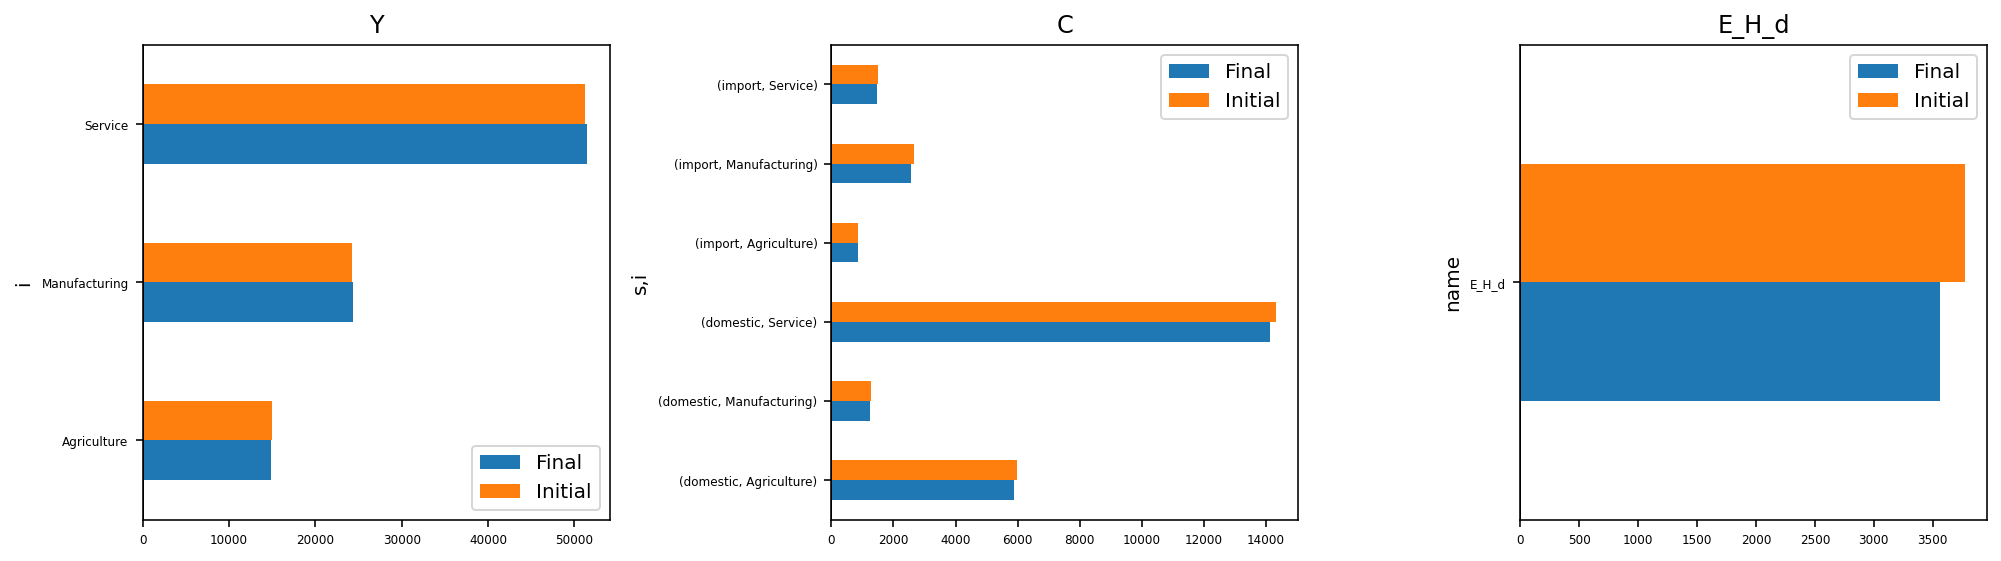

In [242]:
fig = cgp.plot_bar(
    res,
    mod,
    ["Y", "C", "E_H_d"],
    plot_together=False,
    figsize=(14, 4),
    dpi=144,
    orientation="h",
    metric="final_initial",
)

fig.tight_layout()
plt.show()

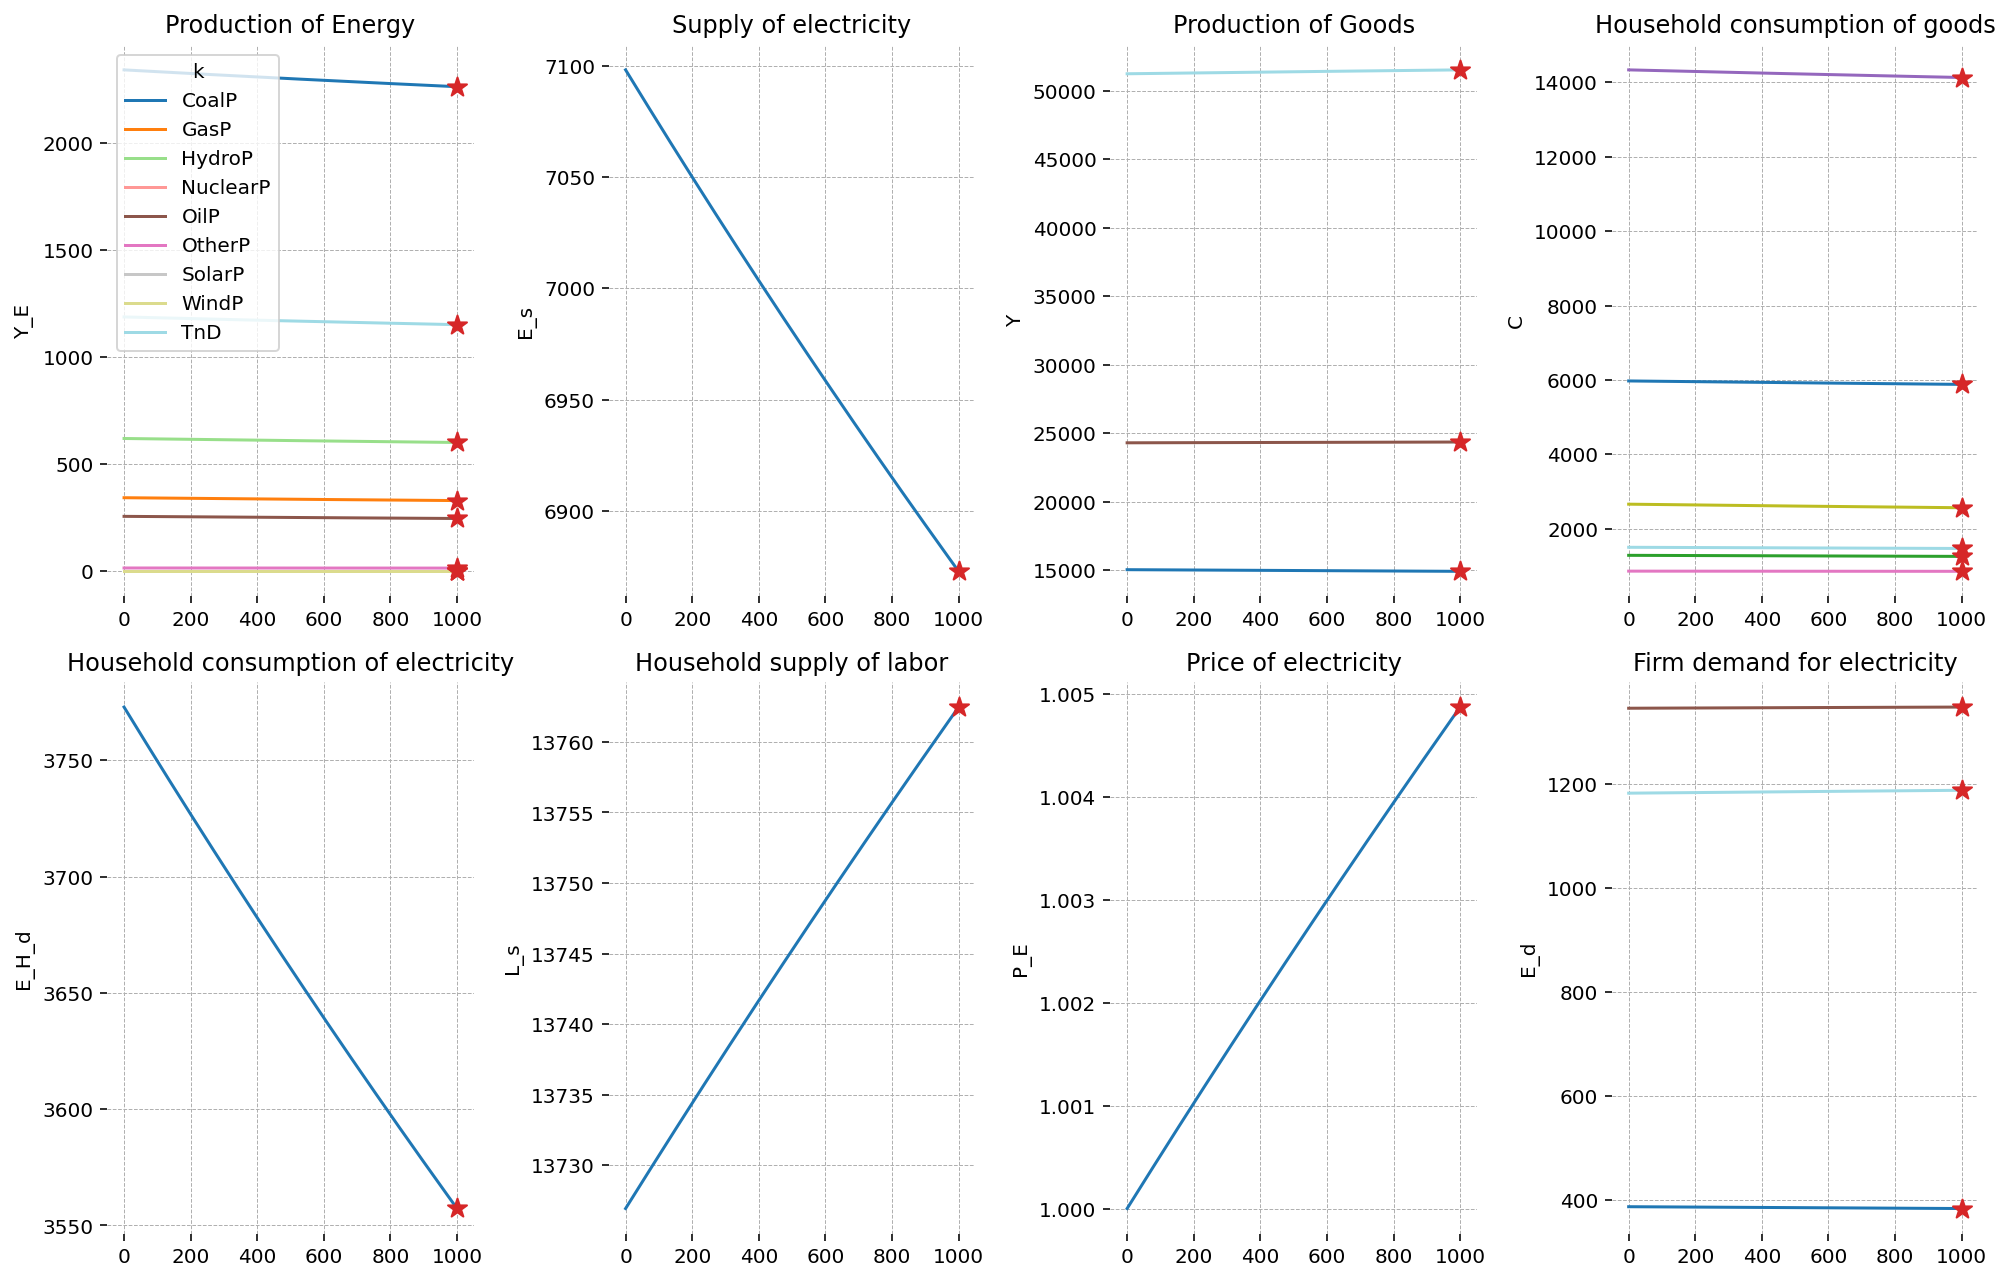

In [38]:
from cge_modeling.plotting import plot_lines

cgp.plot_lines(
    res,
    mod,
    n_cols=4,
    var_names=["Y_E", "E_s", "Y", "C", "E_H_d", "L_s", "P_E", "E_d"],
    figsize=(14, 9),
    dpi=144,
    legends=["Y_E"],
    rename_dict={
        "Y_E": "Production of Energy",
        "E_s": "Supply of electricity",
        "Y": "Production of Goods",
        "C": "Household consumption of goods",
        "E_H_d": "Household consumption of electricity",
        "L_s": "Household supply of labor",
        "P_E": "Price of electricity",
        "E_d": "Firm demand for electricity",
    },
    cmap="tab20",
);